In [1]:
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
import re

import matplotlib.axes as axes
import matplotlib.pyplot as plt
# from google.colab import files

import pandas as pd
import glob
import os

import scipy

In [2]:
# -------------------------------------------------
# Matplotlib settings for thicker lines & bigger fonts
# -------------------------------------------------
plt.rcParams.update({
    'font.size': 18,          # Default text size
    'axes.labelsize': 18,     # Axis label size
    'axes.titlesize': 20,
    'legend.fontsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'lines.linewidth': 2,     # Thicker lines by default
    'lines.markersize': 9,
    'axes.linewidth': 2,
    'xtick.major.size': 10,
    'xtick.major.width': 2,
    'ytick.major.size': 10,
    'ytick.major.width': 2,
    'xtick.minor.size': 5,
    'xtick.minor.width': 1,
    'ytick.minor.size': 5,
    'ytick.minor.width': 1
})

In [12]:
directory = "/Users/jorgegarciaponce/Desktop/Classes/Senior Spring/Physics 191/Plasma/athalia and jorge's data/900v plasma white spectrometer"
neg_files = glob.glob(os.path.join(directory, "*mtorr.txt"))

data = {}
for file in neg_files:
    # Load the file's data
    df = np.loadtxt(file, skiprows=1)
    
    # Get just the filename
    filename = os.path.basename(file)
    
    # Use regex to extract the pressure value (e.g. "151.5")
    match = re.search(r'(\d+\.\d+)\s*mtorr', filename)
    if match:
        pressure = match.group(1)  # This is the extracted pressure as a string
        data[pressure] = df
    else:
        print("Pressure value not found in filename:", filename)

# Now, data's keys are just the pressure values extracted from the filenames.


In [13]:

data['151.7']

array([[ 339.441, 1837.   ],
       [ 339.794, 1828.   ],
       [ 340.147, 1908.   ],
       ...,
       [1017.031, 1621.   ],
       [1017.34 , 1585.   ],
       [1017.649, 1601.   ]], shape=(2048, 2))

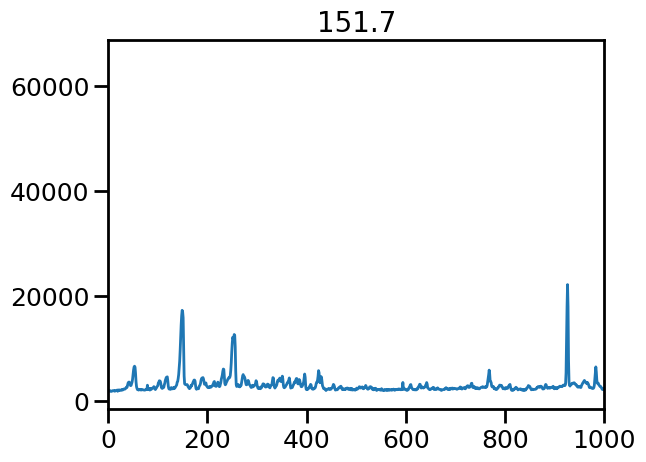

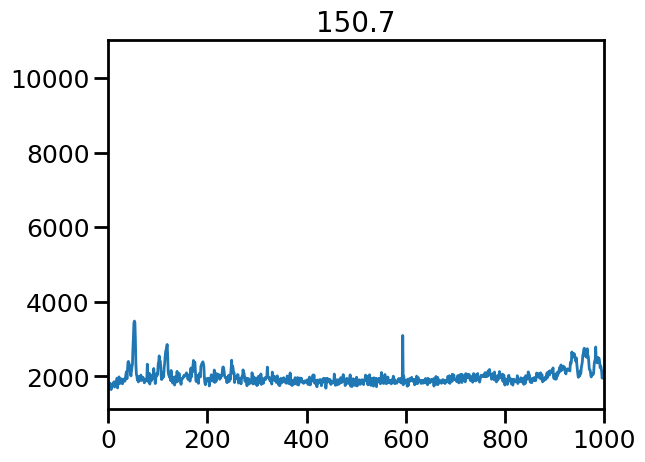

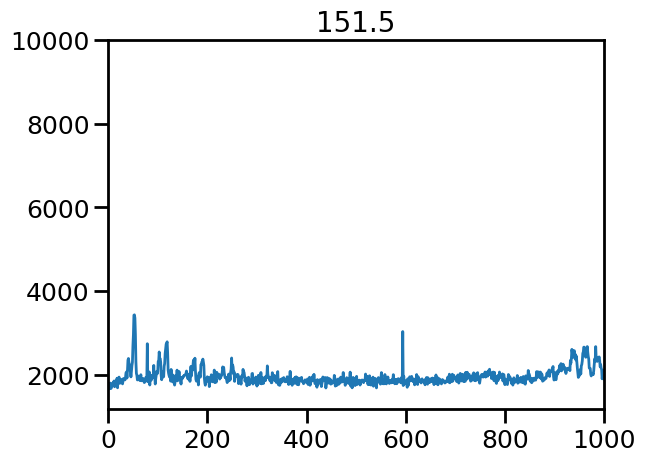

In [5]:
for key, value in data.items():

    plt.plot(value[:,1])
    plt.title(key)
    plt.xlim(0,1000)
    # plt.ylim(0, 5000)
    plt.show()



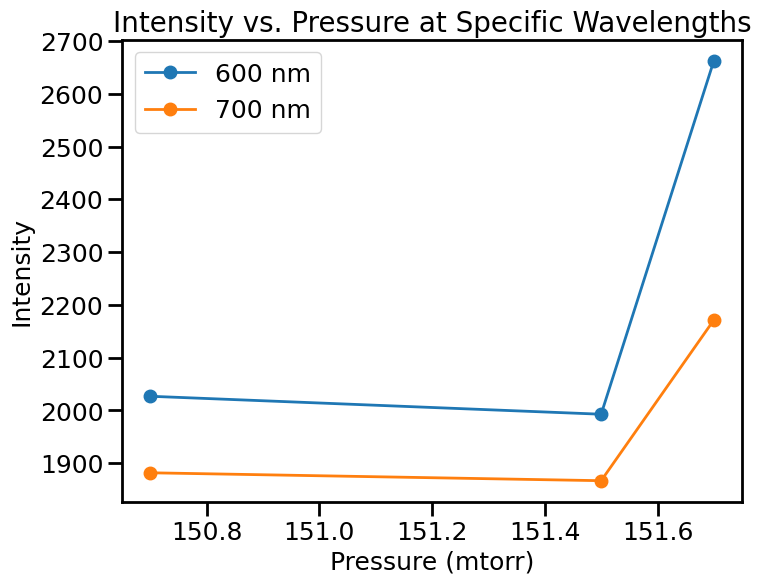

In [6]:
# Define the wavelengths (in nm) at which you want to track intensity
desired_wavelengths = [600, 700]  # Replace with your desired wavelength values

# Get a sorted list of pressures (converted to floats for proper numerical sorting)
sorted_pressures = sorted([float(p) for p in data.keys()])

# Prepare a dictionary to hold the intensity vs pressure data for each desired wavelength
intensities = {wl: [] for wl in desired_wavelengths}

# Loop over pressures in sorted order, extract intensity at the desired wavelength from each file
for p in sorted_pressures:
    # Find the corresponding key in data (as keys are stored as strings)
    # Here we assume that the float conversion gives us a unique match.
    key = None
    for k in data.keys():
        if np.isclose(float(k), p):
            key = k
            break
    if key is None:
        continue  # skip if no matching key

    # Get the spectrum for this pressure
    spectrum = data[key]
    wavelengths = spectrum[:, 0]
    intens_vals = spectrum[:, 1]
    
    # For each desired wavelength, use interpolation to get the intensity
    for wl in desired_wavelengths:
        intensity_at_wl = np.interp(wl, wavelengths, intens_vals)
        intensities[wl].append(intensity_at_wl)

# Now plot intensity vs pressure for each desired wavelength
plt.figure(figsize=(8, 6))
for wl in desired_wavelengths:
    plt.plot(sorted_pressures, intensities[wl], marker='o', label=f'{wl} nm')

plt.xlabel('Pressure (mtorr)')
plt.ylabel('Intensity')
plt.title('Intensity vs. Pressure at Specific Wavelengths')
plt.legend()
plt.show()

In [14]:
import numpy as np
from io import StringIO

data_str = '''\
intensity	Aik	Ek	log thing
5390	1.00E+05	157234.0196	3.64056144
9342	1.64E+07	157673.4134	-1.41462022
16192	3.70E+06	158167.7999	0.538177134
5076	4.50E+05	158428.1087	2.333626097
10221	2.44E+07	161048.7411	-1.804578133
7649	5.60E+06	161048.7411	0.008106618
13522	9.00E+05	161089.3846	2.488681398
11788	8.00E+07	172213.8798	-2.764362008
7537	7.20E+06	183797.4473	-0.895842264
14450	7.70E+06	183986.0137	-0.309425307
5257	3.03E+08	185093.3298	-5.079151284
6409	2.75E+08	185624.8282	-4.786991501
6581	1.76E+08	186340.5616	-4.313237495
'''

# Load the data from the string, skipping the header row.
data_ = np.loadtxt(StringIO(data_str), skiprows=1)

# Extract each column into its own array.
intensity = data_[:, 0]
Aik       = data_[:, 1]
Ek        = data_[:, 2]
log_thing = data_[:, 3]

print("Intensity:", intensity.shape)
print("Aik:", Aik.shape)
print("Ek:", Ek.shape)
print("log thing:", log_thing.shape)



Intensity: (13,)
Aik: (13,)
Ek: (13,)
log thing: (13,)


Slope: -0.000159131
Derived temperature: 9041.46 K


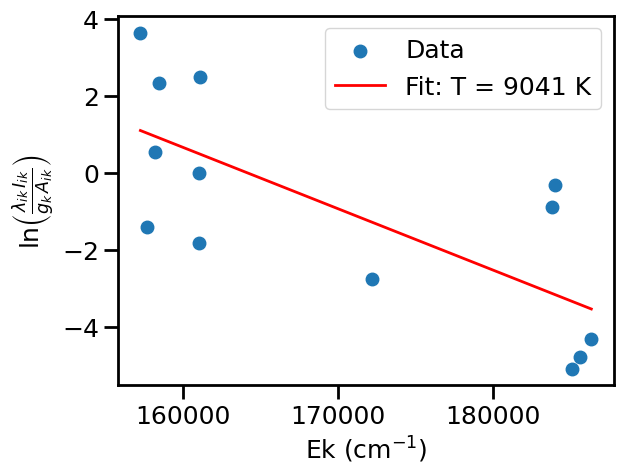

In [15]:
# mask = intensity>7_000

# mask = log_thing > -1000000
# 1. Perform a linear fit (degree=1 means linear)


fit_params = np.polyfit(Ek, log_thing, 1)
slope = fit_params[0]
intercept = fit_params[1]

print(f"Slope: {slope:.6g}")

# 2. Compute temperature, T_e, from the slope.
#    Slope = - (h*c) / (k_B * T_e), if Ek is in cm^{-1}.
#    => T_e = - (h*c) / (k_B * slope)

# Physical constants
k_B = 1.380649e-23        # Boltzmann constant, J/K
hc  = 1.98644586e-23      # Planck's constant * speed of light, J·cm

Te = -hc / (k_B * slope)  # negative sign because slope is typically negative
print(f"Derived temperature: {Te:.2f} K")

# 3. Plot the data and the fitted line
x_fit = np.linspace(Ek.min(), Ek.max(), 100)
y_fit = slope * x_fit + intercept

plt.scatter(Ek, log_thing, label='Data')
plt.plot(x_fit, y_fit, color='red', 
         label=f'Fit: T = {Te:.4g} K')
plt.xlabel('Ek (cm$^{-1}$)')
plt.ylabel(r'$\ln\!\left(\frac{\lambda_{ik}\,I_{ik}}{g_k\,A_{ik}}\right)$')
plt.legend()
plt.show()

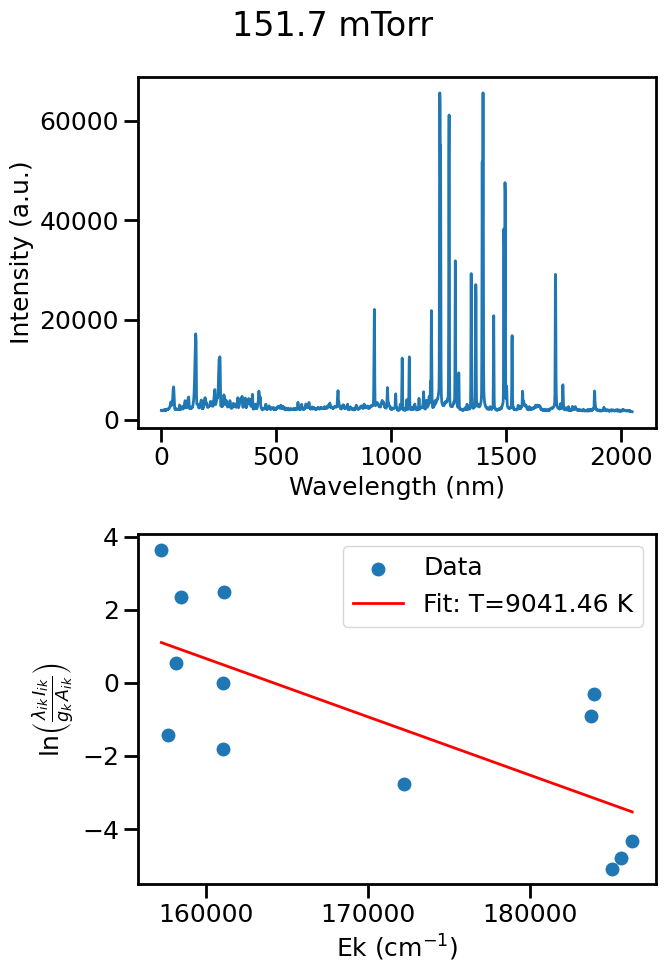

In [30]:
# 4. Create a single row with two plots side-by-side
fig, (ax_left, ax_right) = plt.subplots(nrows=2, ncols=1, figsize=(7, 10))

# -- Left plot: The entire spectrum at 151.7 mtorr --
ax_left.plot(data['151.7'][:, 1])
ax_left.set_xlabel("Wavelength (nm)")   # or whatever the first column is
ax_left.set_ylabel("Intensity (a.u.)")
# ax_left.set_title("151.7 mtorr")
# ax_left.legend()

# -- Right plot: Boltzmann plot with linear fit --
x_fit = np.linspace(Ek.min(), Ek.max(), 100)
y_fit = slope * x_fit + intercept

ax_right.scatter(Ek, log_thing, label="Data")
ax_right.plot(x_fit, y_fit, color='red', label=f"Fit: T={Te:.2f} K")
ax_right.set_xlabel(r"Ek (cm$^{-1}$)")
ax_right.set_ylabel(r'$\ln\!\left(\frac{\lambda_{ik}\,I_{ik}}{g_k\,A_{ik}}\right)$')
# ax_right.set_title("Boltzmann Plot")
ax_right.legend()

fig.suptitle('151.7 mTorr', fontsize=24)


plt.tight_layout()
plt.savefig('../Figures/spectrum_temperature.png', dpi=300)
plt.show()